<a href="https://colab.research.google.com/github/roselinamoven/scaling-fiesta/blob/main/BritishAirways_DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [3]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,"✅ Trip Verified | LHR - SFO, LAS - LGW August..."
1,Not Verified | I flew from Malaga via LHR to...
2,✅ Trip Verified | Milan to Miami return via L...
3,✅ Trip Verified | BA created a new low-cost s...
4,✅ Trip Verified | I flew with British Airway...


In [6]:
df.to_csv("BA_reviews.csv")

In [7]:
import pandas as pd

# Read the CSV file
df = pd.read_csv("BA_reviews.csv")

# Display the first few rows of the dataframe
print(df.head())


   Unnamed: 0                                            reviews
0           0  ✅ Trip Verified |  LHR - SFO, LAS - LGW August...
1           1  Not Verified |   I flew from Malaga via LHR to...
2           2  ✅ Trip Verified |  Milan to Miami return via L...
3           3  ✅ Trip Verified |  BA created a new low-cost s...
4           4  ✅ Trip Verified |   I flew with British Airway...


In [8]:
# Check for any missing values
print(df.isnull().sum())

Unnamed: 0    0
reviews       0
dtype: int64


In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [10]:
nltk.download('punkt')
nltk.download('stopwords')

# Fill missing values
df.fillna('', inplace=True)

# Function to clean text
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\n', ' ', text)  # Remove newline characters
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    return text

# Apply the cleaning function to the review column
df['cleaned_reviews'] = df['reviews'].apply(clean_text)

# Remove stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

df['cleaned_reviews'] = df['cleaned_reviews'].apply(remove_stopwords)

# Display the cleaned reviews
print(df['cleaned_reviews'].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0    trip verified lhr sfo las lgw august club worl...
1    verified flew malaga via lhr boston th may arr...
2    trip verified milan miami return via london wo...
3    trip verified ba created new lowcost subsidiar...
4    trip verified flew british airways heathrow ha...
Name: cleaned_reviews, dtype: object


In [11]:
from textblob import TextBlob


In [12]:
# Function to get the sentiment polarity
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply the function to the cleaned reviews
df['sentiment'] = df['cleaned_reviews'].apply(get_sentiment)

# Display the sentiment scores
print(df[['cleaned_reviews', 'sentiment']].head())

# Basic analysis of sentiment
average_sentiment = df['sentiment'].mean()
print(f"Average Sentiment: {average_sentiment}")

                                     cleaned_reviews  sentiment
0  trip verified lhr sfo las lgw august club worl...   0.096429
1  verified flew malaga via lhr boston th may arr...  -0.029167
2  trip verified milan miami return via london wo...  -0.262500
3  trip verified ba created new lowcost subsidiar...   0.049722
4  trip verified flew british airways heathrow ha...   0.026961
Average Sentiment: 0.06911349765482791


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize the text
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['cleaned_reviews'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(dtm)

# Display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

tf_feature_names = vectorizer.get_feature_names_out()
display_topics(lda, tf_feature_names, 10)


Topic 0:
flight ba british trip airways told london customer hours service
Topic 1:
ba flight service trip airline staff airlines time seat hour
Topic 2:
flight crew service good ba trip cabin food time seats
Topic 3:
class seat ba business seats flight trip food economy good
Topic 4:
flight trip gate london time staff luggage delayed boarding minutes


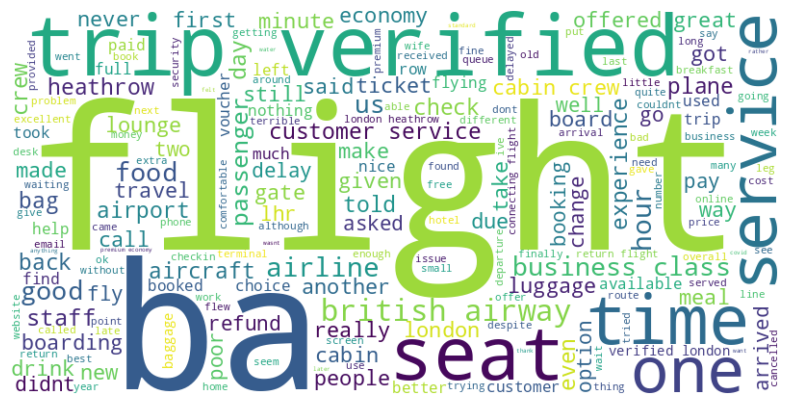

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all reviews into one string
all_reviews = ' '.join(df['cleaned_reviews'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [8]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

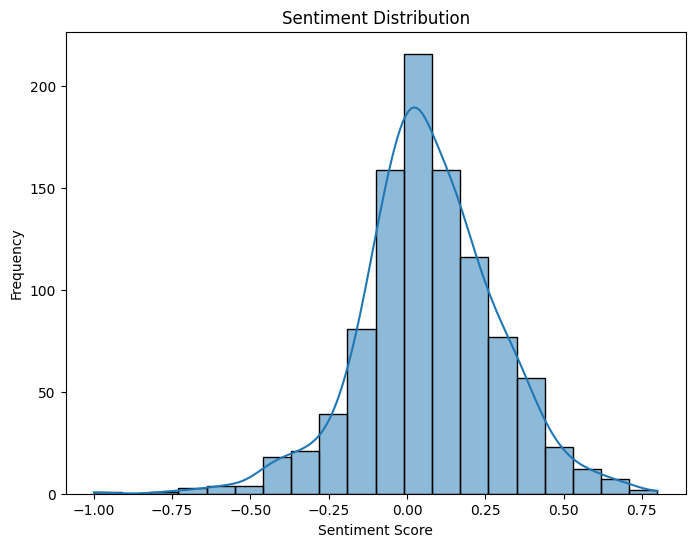

In [20]:
# Plot sentiment distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['sentiment'], kde=True, bins=20)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.savefig('sentiment_distribution.png')
plt.show()



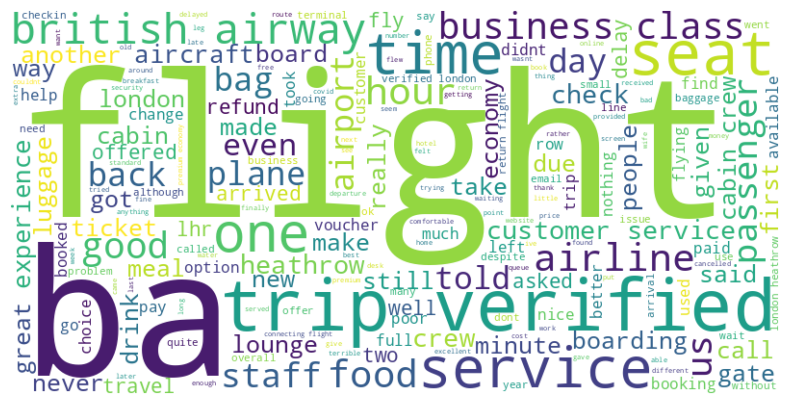

In [21]:
# Topic Modeling
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['cleaned_reviews'])

lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(dtm)

def display_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topics[topic_idx] = " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
    return topics

tf_feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda, tf_feature_names, 10)

# Word Cloud
all_reviews = ' '.join(df['cleaned_reviews'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('wordcloud.png')
plt.show()



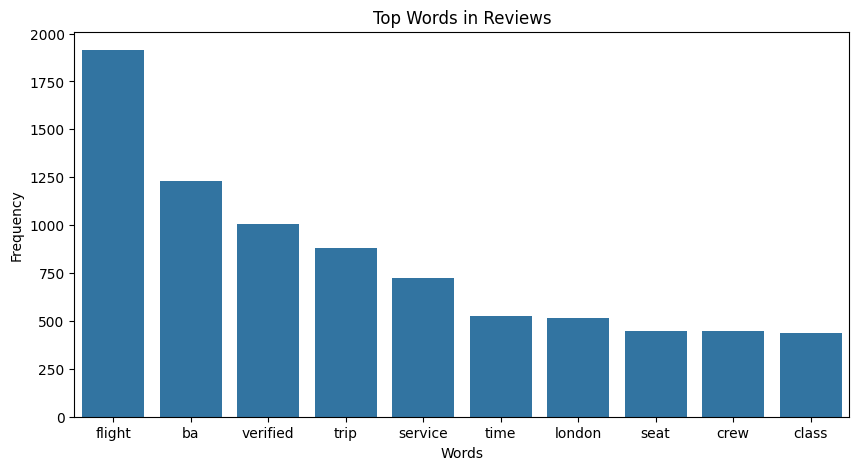

In [23]:
# Top words bar chart
word_freq = Counter(word_tokenize(all_reviews))
most_common_words = word_freq.most_common(10)
words, frequencies = zip(*most_common_words)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(words), y=list(frequencies))
plt.title('Top Words in Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.savefig('top_words.png')
plt.show()

In [10]:
df = pd.read_csv("customer_booking.csv", encoding='latin1')


In [11]:
# Explore the dataset
print(df.head())
print(df.info())
print(df.describe())

   num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0               2      Internet  RoundTrip            262              19   
1               1      Internet  RoundTrip            112              20   
2               2      Internet  RoundTrip            243              22   
3               1      Internet  RoundTrip             96              31   
4               2      Internet  RoundTrip             68              22   

   flight_hour flight_day   route booking_origin  wants_extra_baggage  \
0            7        Sat  AKLDEL    New Zealand                    1   
1            3        Sat  AKLDEL    New Zealand                    0   
2           17        Wed  AKLDEL          India                    1   
3            4        Sat  AKLDEL    New Zealand                    0   
4           15        Wed  AKLDEL          India                    1   

   wants_preferred_seat  wants_in_flight_meals  flight_duration  \
0                     0        

In [12]:
# Check for missing values
print(df.isnull().sum())

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64


In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder


In [15]:
# Split data into features and target
X = df.drop('booking_complete', axis=1)  # Assuming 'booking' is the target column
y = df['booking_complete']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
from sklearn.preprocessing import OneHotEncoder

# Assuming X_train is your input data containing categorical variables
# Assuming categorical_features is a list of indices or column names of categorical features in X_train
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
categorical_features=["sales_channel"]
X_train_encoded = encoder.fit_transform(X_train[categorical_features])


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [27]:

X_train_encoded

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [29]:
# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_encoded, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(rf, X_train_encoded, y_train, cv=5, scoring='roc_auc')
print(f'Cross-validation ROC AUC scores: {cv_scores}')
print(f'Mean CV ROC AUC score: {cv_scores.mean()}')

# Predict on the test set
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# Evaluation metrics
print(classification_report(y_test, y_pred))
print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}')
print(f'Test ROC AUC score: {roc_auc_score(y_test, y_pred_proba)}')

# Feature importance
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Cross-validation ROC AUC scores: [0.52107268 0.52548928 0.51696963 0.51502517 0.51740892]
Mean CV ROC AUC score: 0.5191931382214701


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: could not convert string to float: 'Internet'

Test Score: 0.832
                        feature  importance
571    remainder__purchase_lead    0.103462
573      remainder__flight_hour    0.093599
572   remainder__length_of_stay    0.089891
577  remainder__flight_duration    0.046614
570   remainder__num_passengers    0.038053


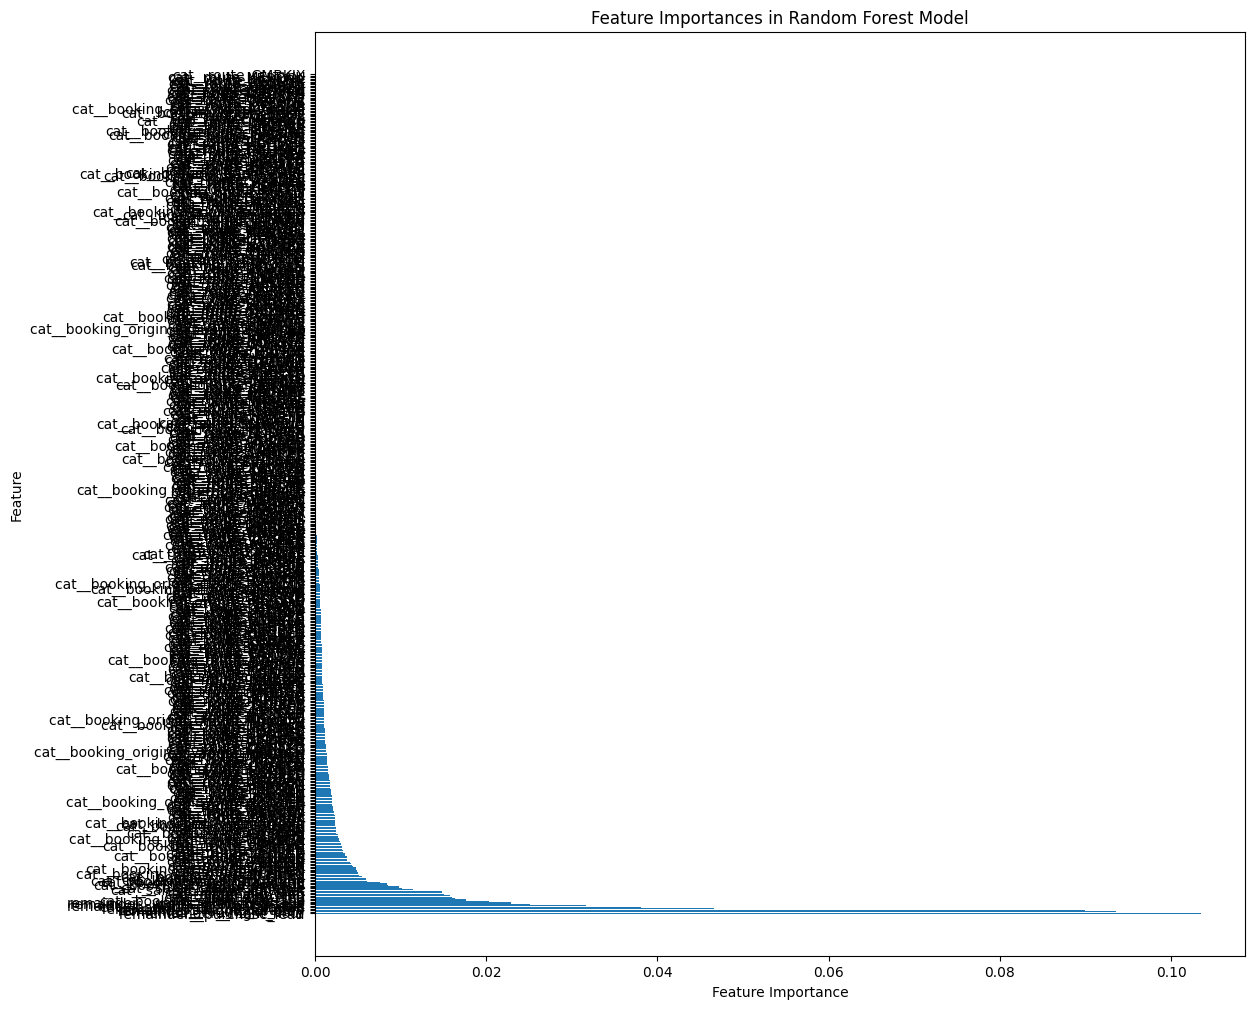

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('customer_booking.csv', encoding='latin1')

# Define categorical and numerical features
categorical_features = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']
numerical_features = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
                      'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration']

# Separate features and target variable
X = df[categorical_features + numerical_features]
y = df['booking_complete']

# Using a subset of the data for quicker processing
df_subset = df.sample(frac=0.1, random_state=42)  # Use 10% of the data

# Separate features and target variable for the subset
X_subset = df_subset[categorical_features + numerical_features]
y_subset = df_subset['booking_complete']

# Split the subset data into training and testing sets
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_subset, y_subset, test_size=0.3, random_state=42)

# Preprocessing pipeline for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as they are
)

# Create a pipeline that first transforms the data, then fits the model
pipeline_sub = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the model on the subset training data
pipeline_sub.fit(X_train_sub, y_train_sub)

# Evaluate the model on the subset test data
test_score_sub = pipeline_sub.score(X_test_sub, y_test_sub)

# Get feature importances from the trained model on the subset
rf_model_sub = pipeline_sub.named_steps['classifier']
encoded_feature_names_sub = pipeline_sub.named_steps['preprocessor'].get_feature_names_out()
importances_sub = rf_model_sub.feature_importances_

# Create a DataFrame for feature importances
feature_importances_sub = pd.DataFrame({
    'feature': encoded_feature_names_sub,
    'importance': importances_sub
}).sort_values(by='importance', ascending=False)

# Display the test score and feature importances
print(f'Test Score: {test_score_sub}')
print(feature_importances_sub.head())

# Plot feature importances
plt.figure(figsize=(12, 12))
plt.barh(feature_importances_sub['feature'], feature_importances_sub['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Model')
plt.show()


Test Score: 0.832
                              feature  importance
571          remainder__purchase_lead    0.103462
573            remainder__flight_hour    0.093599
572         remainder__length_of_stay    0.089891
577        remainder__flight_duration    0.046614
570         remainder__num_passengers    0.038053
545      cat__booking_origin_Malaysia    0.031634
576  remainder__wants_in_flight_meals    0.025078
575   remainder__wants_preferred_seat    0.022906
574    remainder__wants_extra_baggage    0.020337
523     cat__booking_origin_Australia    0.017654
10                cat__flight_day_Tue    0.016370
11                cat__flight_day_Wed    0.015944
9                 cat__flight_day_Thu    0.015799
5                 cat__flight_day_Fri    0.015043
6                 cat__flight_day_Mon    0.014845
8                 cat__flight_day_Sun    0.014797
7                 cat__flight_day_Sat    0.011422
0         cat__sales_channel_Internet    0.010174
1           cat__sales_channel_M

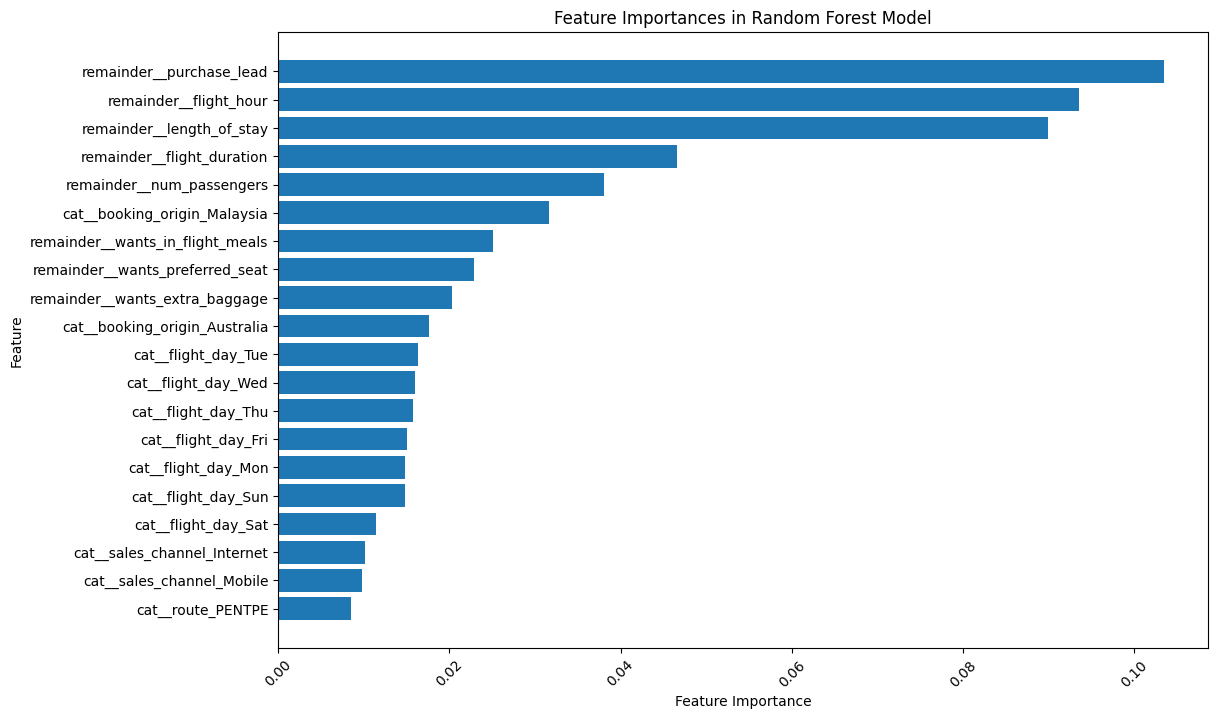

In [10]:
# Function to plot feature importances with adjustments
def plot_feature_importances(feature_importances, top_n=None):
    if top_n:
        # Select the top N features if specified
        feature_importances = feature_importances.head(top_n)

    plt.figure(figsize=(12, 8))  # Increase figure size for better readability
    plt.barh(feature_importances['feature'], feature_importances['importance'])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances in Random Forest Model')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.yticks(fontsize=10)  # Adjust y-axis label font size
    plt.show()

# Display the test score and top 20 feature importances (adjust as needed)
print(f'Test Score: {test_score_sub}')
print(feature_importances_sub.head(20))

# Plot the top 20 feature importances
plot_feature_importances(feature_importances_sub, top_n=20)